In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, auc

In [146]:
df = pd.read_csv(' https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/Fraud_Detection_Dataset.csv')
df

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No
...,...,...,...,...,...,...,...,...,...,...
9995,9996,1524,1475.988992,2023-01-07 22:35:00,Clothing,Los Angeles,95.068658,414.231539,desktop,Yes
9996,9997,4879,764.834233,2023-01-07 22:36:00,Clothing,Los Angeles,902.506946,1090.687430,mobile,No
9997,9998,2624,882.096776,2023-01-07 22:37:00,Travel,New York,531.237353,186.667431,mobile,No
9998,9999,4907,1.000000,2023-01-07 22:38:00,Dining,Chicago,0.000000,116.343224,desktop,No


In [147]:
df.describe()

,Transaction ID,Customer ID,Transaction Amount,Previous Transaction Amount,Time Since Last Transaction
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,3010.561100,559.865608,461.410984,677.040726
std,2886.89568,1152.371939,399.984400,334.582413,432.386769
min,1.00000,1000.000000,1.000000,0.000000,1.000000
25%,2500.75000,2001.750000,262.969956,181.109688,295.523894
50%,5000.50000,3004.000000,522.370941,404.367010,653.143168
75%,7500.25000,4010.000000,788.415931,676.079655,1048.479972
max,10000.00000,4999.000000,2953.394492,1500.000000,1694.715674


In [148]:
df.isnull().sum()
num_feature=[feature for feature in df.columns if df[feature].dtypes!='object']
num_feature

['Transaction ID',
 'Customer ID',
 'Transaction Amount',
 'Previous Transaction Amount',
 'Time Since Last Transaction']

In [149]:
cat_feature=[feature for feature in df.columns if df[feature].dtypes=='object']
cat_feature
for feature in cat_feature:
    print(feature, len(df[feature].unique()))

Transaction Date and Time 10000
Merchant Category 5
Location 5
Device Type 2
Fraud 2


# EDA

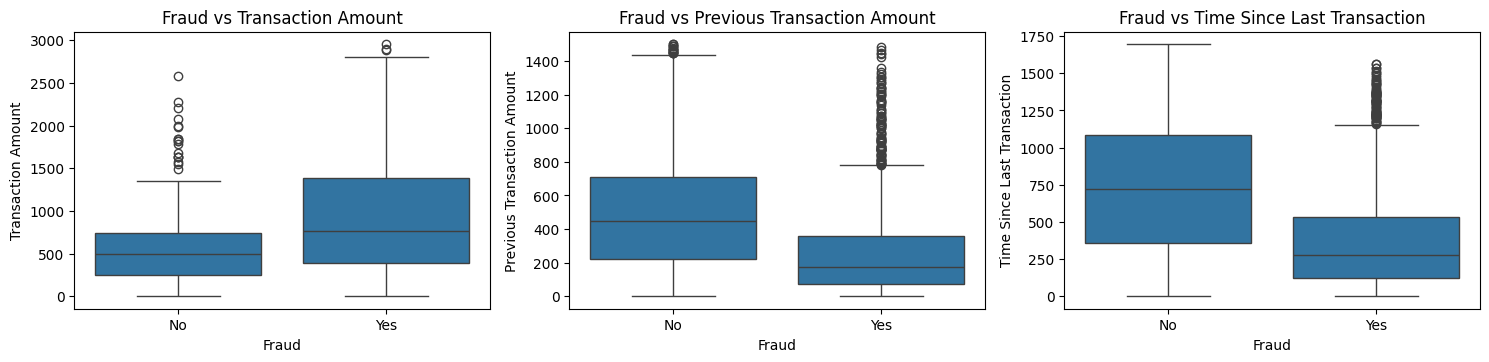

In [150]:
columns_to_plot = ['Transaction Amount', 'Previous Transaction Amount', 'Time Since Last Transaction']

plt.figure(figsize=(15, 10))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x='Fraud', y=column)
    plt.title(f'Fraud vs {column}')
    plt.tight_layout()

plt.show()

##### The three boxplot shows the difference between 'transction amount', 'last transaction amount' and 'time since last purchase' with respect to whether the transaction is a fraud or not. All plots shows notable difference in the median values between fraudulent and non-fraudulent transactions. 

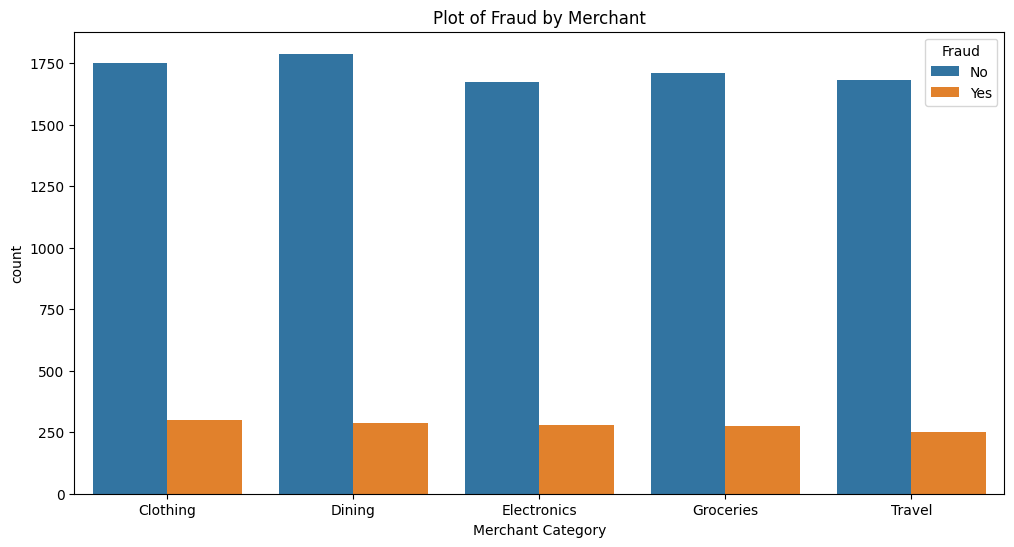

In [151]:
plt.figure(figsize=(12, 6))
sns.countplot(x=df['Merchant Category'], hue=df['Fraud'])
plt.title('Plot of Fraud by Merchant')
plt.show()

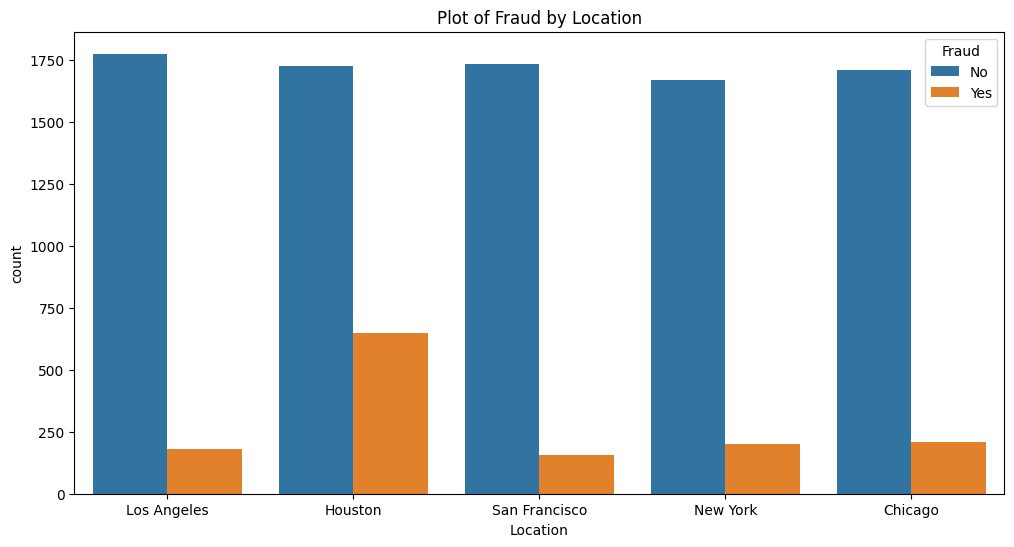

In [152]:
plt.figure(figsize=(12, 6))
sns.countplot(x=df['Location'], hue=df['Fraud'])
plt.title('Plot of Fraud by Location')
plt.show()

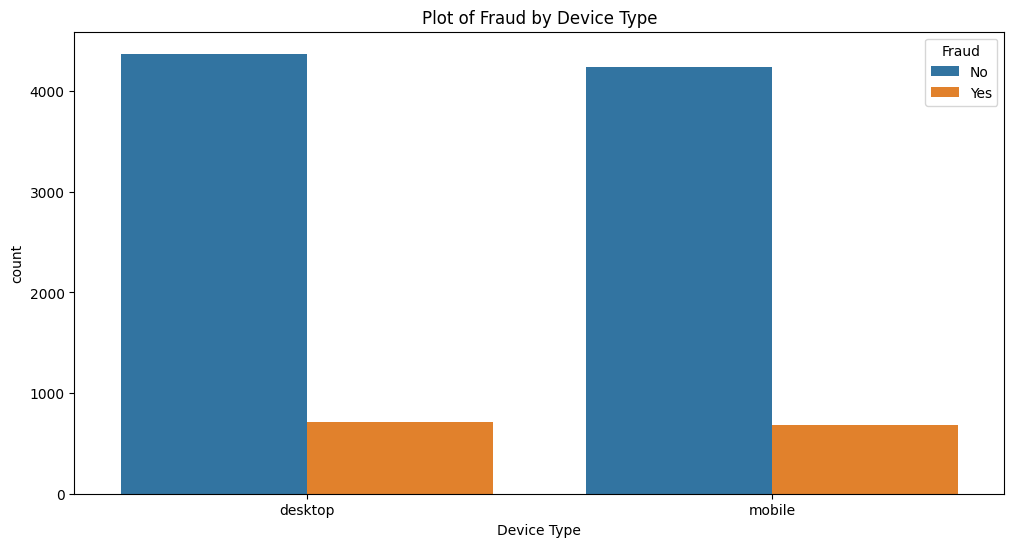

In [153]:
plt.figure(figsize=(12, 6))
sns.countplot(x=df['Device Type'], hue=df['Fraud'])
plt.title('Plot of Fraud by Device Type')
plt.show()

##### The three plots show the countplot of the number of fraud and non-fraud with respect to 'location', 'merchant category' and 'device type'. Among all plots, only one plot shows a notable difference in the percentage of fraud, which is the countplot of location. The province Houston shows a significantly larger proportion of fraudulent transactions compared with other provinces. 

In [154]:
df['Fraud'] = df['Fraud'].replace({'No': 0, 'Yes': 1})
df


/var/folders/ft/gq7wv6zs1slgbv35cnp736j00000gp/T/ipykernel_50773/3917766331.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Fraud'] = df['Fraud'].replace({'No': 0, 'Yes': 1})


,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,0
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,0
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,0
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,0
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,0
...,...,...,...,...,...,...,...,...,...,...
9995,9996,1524,1475.988992,2023-01-07 22:35:00,Clothing,Los Angeles,95.068658,414.231539,desktop,1
9996,9997,4879,764.834233,2023-01-07 22:36:00,Clothing,Los Angeles,902.506946,1090.687430,mobile,0
9997,9998,2624,882.096776,2023-01-07 22:37:00,Travel,New York,531.237353,186.667431,mobile,0
9998,9999,4907,1.000000,2023-01-07 22:38:00,Dining,Chicago,0.000000,116.343224,desktop,0


<Axes: >

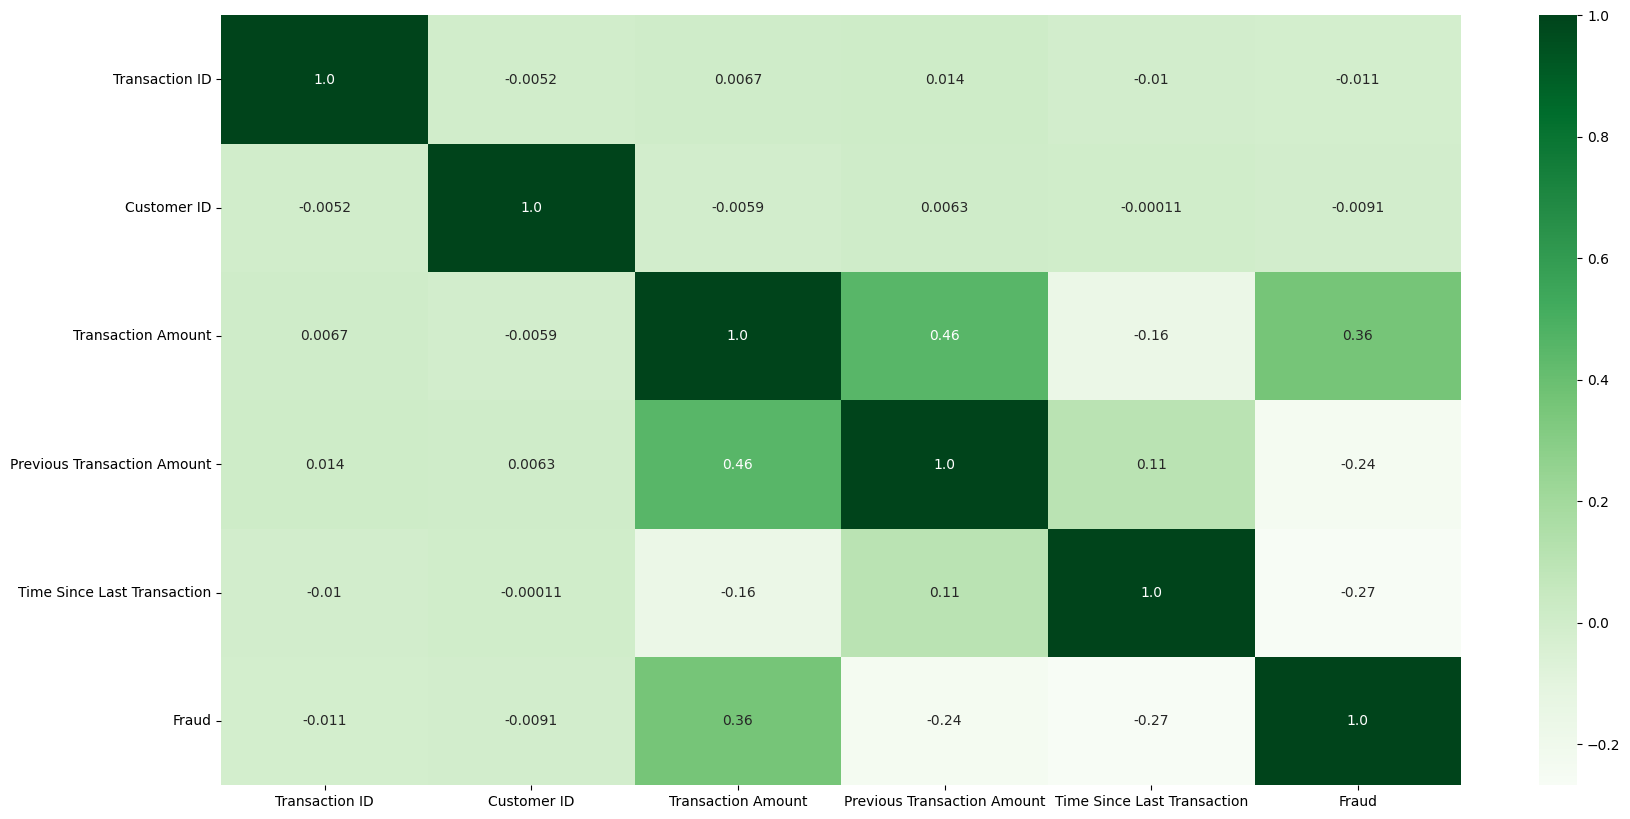

In [155]:
num_feature.append('Fraud')
cor=df[num_feature].corr()
plt.figure(figsize=(20,10))
sns.heatmap(cor,annot=True,cmap='Greens',fmt='.2')

##### From the correlation heatmap we can identify several variables that seem to have relationship with being fraudulent or not. 'Transaction amount', 'Previous Transaction amount' and 'Time since last purchase' all have coefficients greater that the absolute value of 0.2. 
##### Therefore, my hypothesis is Transaction amount, Previous Transaction amount and Time since last purchase all have significant impact on the fraudulent status of each transaction. 

# Feature Engineering

In [156]:
df['Device Type'] = df['Device Type'].replace({'mobile': 0, 'desktop': 1})
df['Location'] = df['Location'].replace({'Los Angeles': 0, 'Houston': 1, 'San Francisco':0,'New York':0, 'Chicago':0 })
df

/var/folders/ft/gq7wv6zs1slgbv35cnp736j00000gp/T/ipykernel_50773/3567572227.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Device Type'] = df['Device Type'].replace({'mobile': 0, 'desktop': 1})
/var/folders/ft/gq7wv6zs1slgbv35cnp736j00000gp/T/ipykernel_50773/3567572227.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Location'] = df['Location'].replace({'Los Angeles': 0, 'Houston': 1, 'San Francisco':0,'New York':0, 'Chicago':0 })


,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,0,579.323704,481.377516,1,0
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,1,407.220271,1159.211075,1,0
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,0,265.583605,720.677284,1,0
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,0,1097.259081,1.000000,0,0
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,0,238.389682,1378.958721,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,9996,1524,1475.988992,2023-01-07 22:35:00,Clothing,0,95.068658,414.231539,1,1
9996,9997,4879,764.834233,2023-01-07 22:36:00,Clothing,0,902.506946,1090.687430,0,0
9997,9998,2624,882.096776,2023-01-07 22:37:00,Travel,0,531.237353,186.667431,0,0
9998,9999,4907,1.000000,2023-01-07 22:38:00,Dining,0,0.000000,116.343224,1,0


In [157]:
class_counts = df['Fraud'].value_counts()
print("Class distribution:\n", class_counts)
num_feature=[feature for feature in df.columns if df[feature].dtypes!='object']
num_feature

Class distribution:
 Fraud
0    8608
1    1392
Name: count, dtype: int64


['Transaction ID',
 'Customer ID',
 'Transaction Amount',
 'Location',
 'Previous Transaction Amount',
 'Time Since Last Transaction',
 'Device Type',
 'Fraud']

# Modelling

In [158]:
X = df[['Transaction Amount','Location',
 'Previous Transaction Amount',
 'Time Since Last Transaction',
 'Device Type']]
X
y = df['Fraud']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

### Cross Validation

In [159]:
knn = KNeighborsClassifier()
logreg = LogisticRegression(max_iter=10000)
nb = GaussianNB()
dt = DecisionTreeClassifier()
svc=SVC()

knn_scores = cross_val_score(knn, X_train, y_train, scoring= 'recall', cv=5)
logreg_scores = cross_val_score(logreg, X_train, y_train, scoring='recall', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='recall', cv=5)
svc_scores = cross_val_score(svc,X_train, y_train, scoring='recall', cv=5)
dt_scores = cross_val_score(dt,X_train, y_train, scoring='recall', cv=5)


print(f'Logistic Regression Mean F1 Score: {np.mean(logreg_scores)}')
print(f'K-Nearest Neighbors Mean F1 Score: {np.mean(knn_scores)}')
print(f'NB Classifier Mean F1 Score: {np.mean(nb_scores)}')
print(f'SVC Classifier Mean F1 Score: {np.mean(svc_scores)}')
print(f'DT Classifier Mean F1 Score: {np.mean(dt_scores)}')

Logistic Regression Mean F1 Score: 0.5010202527790467
K-Nearest Neighbors Mean F1 Score: 0.6199533018628496
NB Classifier Mean F1 Score: 0.4717679305619004
SVC Classifier Mean F1 Score: 0.5715547434140398
DT Classifier Mean F1 Score: 0.6088827978275214


### KNN Classifier

KNN Classifier - Accuracy: 0.943
KNN Classifier - Precision: 0.922509225092251
KNN Classifier - Recall: 0.625
KNN Classifier - F1 Score: 0.7451564828614009
Confusion Matrix:
[[2579   21]
 [ 150  250]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2600
           1       0.92      0.62      0.75       400

    accuracy                           0.94      3000
   macro avg       0.93      0.81      0.86      3000
weighted avg       0.94      0.94      0.94      3000



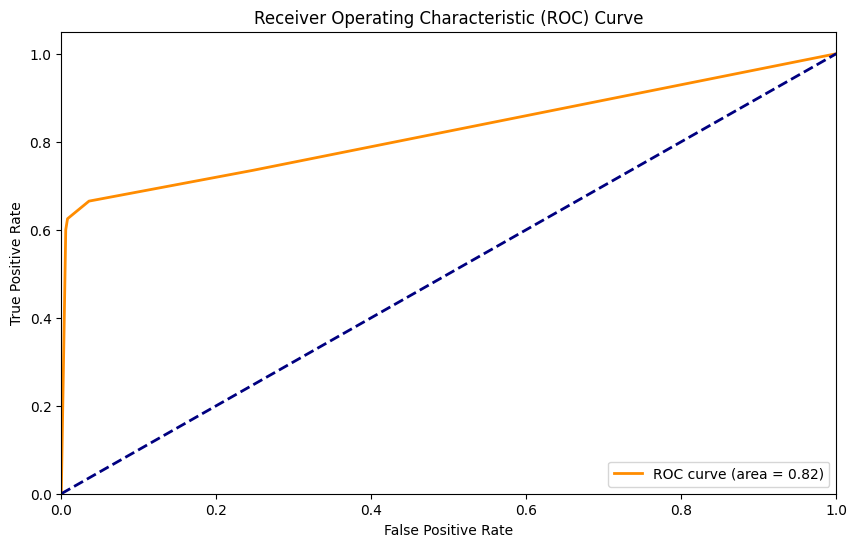

In [160]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
conf_matrix = confusion_matrix(y_test, y_pred_knn)
print(f'KNN Classifier - Accuracy: {accuracy}')
print(f'KNN Classifier - Precision: {precision}')
print(f'KNN Classifier - Recall: {recall}')
print(f'KNN Classifier - F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(classification_report(y_test, y_pred_knn))

y_prob_knn = knn_classifier.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob_knn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 23.52222222222222, 'Predicted Classes')

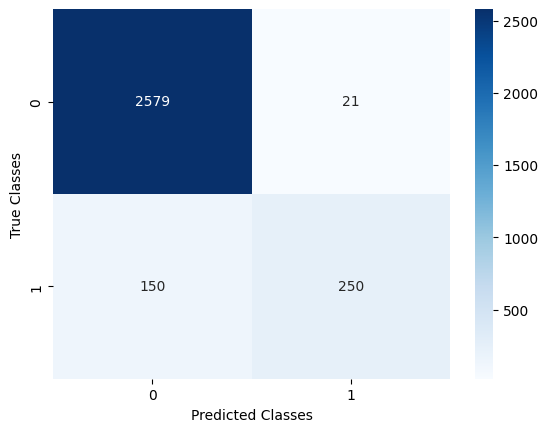

In [161]:
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True,cmap='Blues',fmt='d')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')

##### The accuracy and precision for the KNN model is both pretty high, indicating a good performance in predicting. However, the recall score is relatively low, especially for the postive group. This indicates that already with great ability to predict actual fraud, the false negative rate is also high, meaning that the number of fraudulent transactions that go undetected is large. This can also be indicated from the confusion matrix, whether 150 actual fraud transactions goes undetected. 
##### One of the weakness of KNN mode is its sensitivity to imbalanced data. The dataset we have is quite imbalanced, therefore I will not be choosing this model, even it has the lowest False Positive predictions.

### Decision Tree

Decision Tree - Accuracy: 0.89
Decision Tree - Precision: 0.5825471698113207
Decision Tree - Recall: 0.6175
Decision Tree - F1 Score: 0.5995145631067961
[[2423  177]
 [ 153  247]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2600
           1       0.58      0.62      0.60       400

    accuracy                           0.89      3000
   macro avg       0.76      0.77      0.77      3000
weighted avg       0.89      0.89      0.89      3000



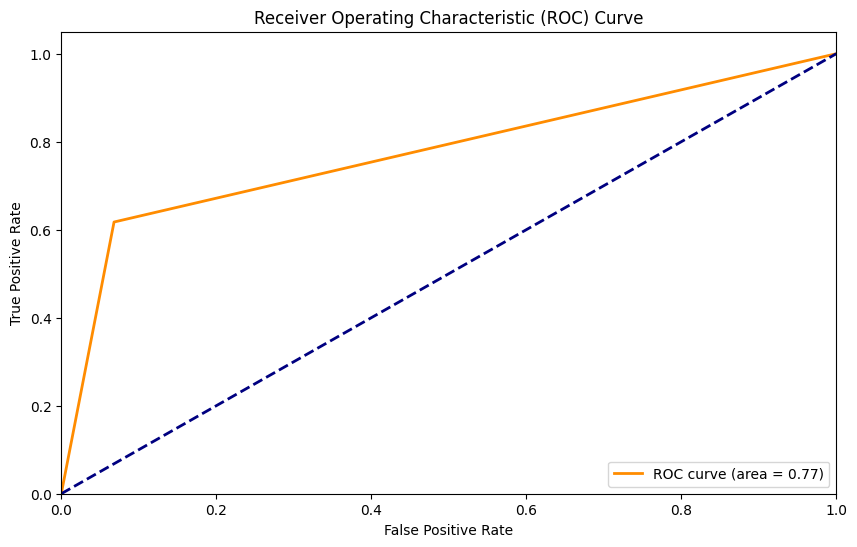

In [162]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)
conf_matrix = confusion_matrix(y_test, y_pred_dt)
print(f'Decision Tree - Accuracy: {accuracy}')
print(f'Decision Tree - Precision: {precision}')
print(f'Decision Tree - Recall: {recall}')
print(f'Decision Tree - F1 Score: {f1}')
print(conf_matrix)
print(classification_report(y_test, y_pred_dt))

y_prob_dt = dt.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob_dt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 23.52222222222222, 'Predicted Classes')

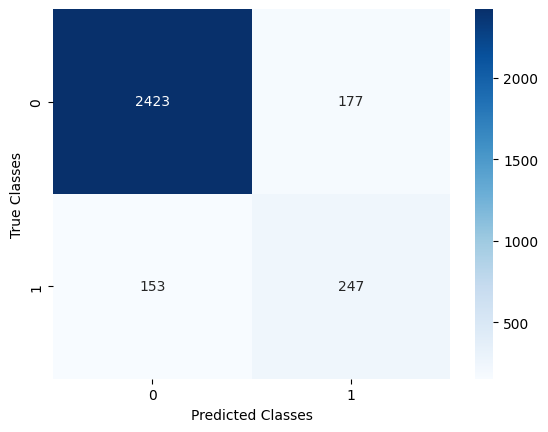

In [163]:
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True,cmap='Blues',fmt='d')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')

##### The decision tree model shows pretty similar result with the KNN model, where the precision and accuracy are high and recall is relatively low. The decision tree model even shows higher False Positive rate, where the number of legitimate transactions flagged as fraud is higher than the KNN model.
##### Compared with KNN model, decistion model have notable increase in the False Positive cases, shown as the 177 of legitimate transactions flagged as fraud.

Logistic Regression - Accuracy: 0.8523333333333334
Logistic Regression - Precision: 0.8828144537498734
Logistic Regression - Recall: 0.8523333333333334
Logistic Regression - F1 Score: 0.8636582666095494
[[2284  316]
 [ 127  273]]
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      2600
           1       0.46      0.68      0.55       400

    accuracy                           0.85      3000
   macro avg       0.71      0.78      0.73      3000
weighted avg       0.88      0.85      0.86      3000



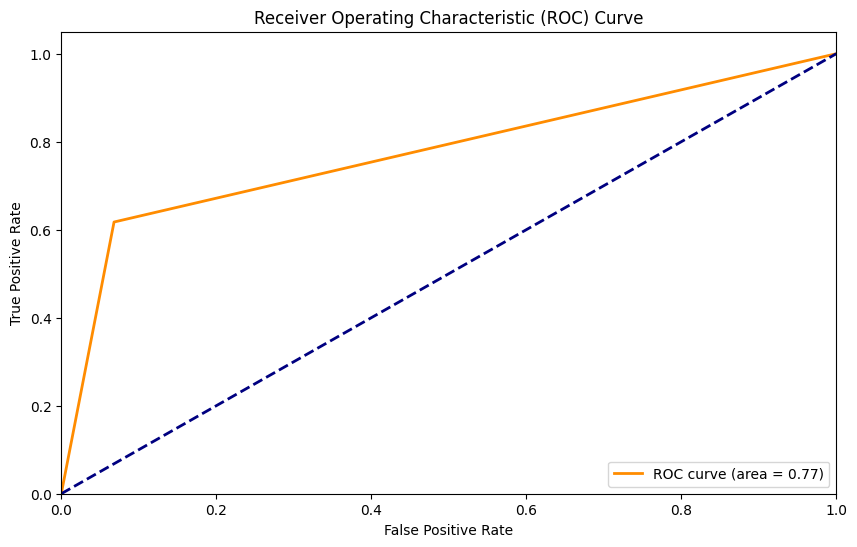

In [164]:
# weighted in result
logreg = LogisticRegression(class_weight='balanced', random_state=42,max_iter=10000)
logreg.fit(X_train, y_train)
y_pred_logistic = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_logistic)
precision = precision_score(y_test, y_pred_logistic, average='weighted')
recall = recall_score(y_test, y_pred_logistic, average='weighted')
f1 = f1_score(y_test, y_pred_logistic, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_logistic)
print(f'Logistic Regression - Accuracy: {accuracy}')
print(f'Logistic Regression - Precision: {precision}')
print(f'Logistic Regression - Recall: {recall}')
print(f'Logistic Regression - F1 Score: {f1}')
print(conf_matrix)
print(classification_report(y_test, y_pred_logistic))

y_prob_logistic = dt.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob_logistic)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 23.52222222222222, 'Predicted Classes')

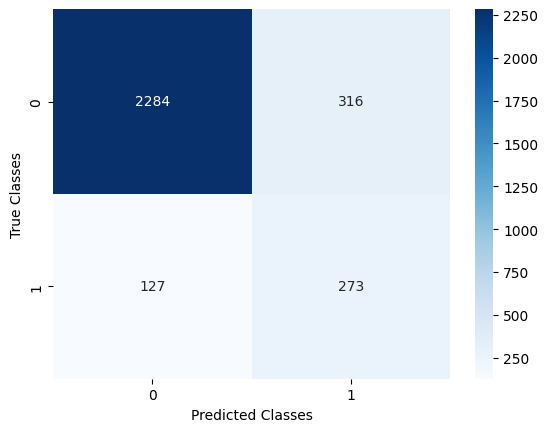

In [165]:
sns.heatmap(confusion_matrix(y_test, y_pred_logistic), annot=True,cmap='Blues',fmt='d')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')

##### Logistics regression does pretty similar as well, the recall is slightly higher most attribute to predciting negatives. The model does have a lower False Negative but much higher in False Postive cases. With 316 legitimate transactions flagged as fraud, compared with 21 and 177 from the other two models.
##### Therefore, I will not be choosing this model, because I want to minimize the number of False positive predictions as well as False positive predictions.

# Improvment

In [166]:

param_dist_tree = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'class_weight': ['balanced', None]
}

random_search_tree = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_distributions=param_dist_tree, 
                                        n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
X_resampled, y_resampled = smote.fit_resample(X, y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
random_search_tree.fit(X_scaled, y_resampled)

print("Best parameters found for Decision Tree: ", random_search_tree.best_params_)
print("Best ROC AUC score for Decision Tree: ", random_search_tree.best_score_)

best_tree = random_search_tree.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

best_tree.fit(X_train, y_train)

y_pred_dt = best_tree.predict(X_test)
y_prob_dt = best_tree.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob_dt)
roc_auc = auc(fpr, tpr)


Best parameters found for Decision Tree:  {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_leaf': 12, 'min_samples_split': 6}
Best ROC AUC score for Decision Tree:  0.9200550245848994


Decision Tree - Accuracy: 0.8414634146341463
Decision Tree - Precision: 0.8451118963486455
Decision Tree - Recall: 0.8352735739231665
Decision Tree - F1 Score: 0.8401639344262295
Confusion Matrix for Decision Tree:
[[1463  263]
 [ 283 1435]]

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1726
           1       0.85      0.84      0.84      1718

    accuracy                           0.84      3444
   macro avg       0.84      0.84      0.84      3444
weighted avg       0.84      0.84      0.84      3444



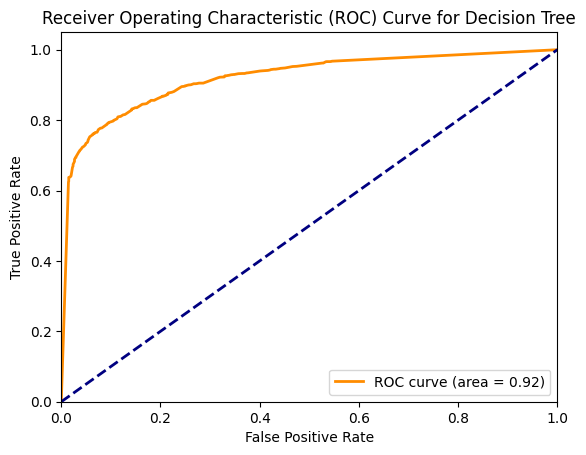

In [167]:
accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)
conf_matrix = confusion_matrix(y_test, y_pred_dt)
print(f'Decision Tree - Accuracy: {accuracy}')
print(f'Decision Tree - Precision: {precision}')
print(f'Decision Tree - Recall: {recall}')
print(f'Decision Tree - F1 Score: {f1}')
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 23.52222222222222, 'Predicted Classes')

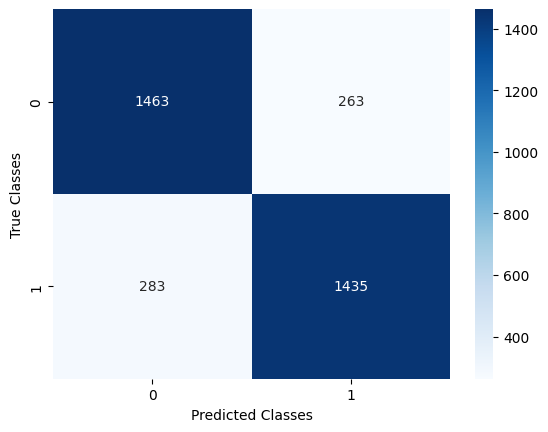

In [168]:
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True,cmap='Blues',fmt='d')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')

##### My final model selection is Decision Tree Classifier. The original model shows quite promising accuracy score, with a moderate precision and recall scores. In the model improvement, I applied standard scaler to scale the data, as well we resampling technique to mitigate the imbalance problem in the original dataset to make better predictions. The result from Gridsearch shows that best parameters found for Decision Tree is 'class_weight': 'balanced', 'max_depth': 30, 'min_samples_leaf': 12, 'min_samples_split': 6. 
##### The post tuning auc is now 0.92, the pre tuning was 0.77, which shows a notable increase. The precision increases from 0.58 to 0.845, the recall increases from 0.62 to 0.835. Both shows quite significant increases, increase in recall indicated that the False Negative, which is the number of fraudulent transactions that go undetected reduces. Increase in precision indicates that the false positve decreases, the number of fraudulent transactions that go undetected reduces. 

# Business Insight

##### The hypothesis is Transaction amount, Previous Transaction amount and Time since last purchase all have significant impact on the fraudulent status of each transaction. The parameters in the training and testing data all seem meaningful in predicting the final fraudulent result, therefore the hypothesis is significant. 

##### The optimized model can now be used by the business to minimize the number of fraudulent transactions that go undetected and reduce the number of legitimate transactions flagged as fraud. The model has high precision,accuracy and recall scores, which indicates its strong ability to make predictions based on the user data. 

##### In addition, the business can now be aware of customers with lower precious transaction amount and who place order in a short period of time, to better detect frauds in transactions. 
